# CORELS

Preparing for fitting an interpretable model like CORELS. I have to bin features first.

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from imodels import FIGSClassifier, FIGSRegressor, get_clean_dataset, FIGSClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier as xgb
import seaborn as sns

### Reading in the data

In [2]:
visual_data = pd.read_csv("visual_data.csv")

In [3]:
visual_data.shape

(13855, 10)

In [4]:
complete_data = pd.read_csv("complete_data_499.csv")

In [5]:
cdf = pd.read_csv("cdf_499.csv")

In [6]:
cdf['EXTRAS_ID'] = np.array([str(s)[2:-1] for s in cdf['EXTRAS_ID']])

In [7]:
cdf.head()

Unnamed: 0         OBS_ID  SRC_NUM  BIN_SIZE     F_VAR  F_VAR_ERR  \
0           2  b'0000110101'        1       499  0.692592   0.165601   
1           6  b'0000110101'        2       499  0.997198   0.264032   
2          10  b'0000110101'        3       499  0.788664   0.615132   
3          14  b'0000110101'        4       499  1.926109   1.752167   
4          18  b'0000110101'        5       499  1.662160   0.516661   

            AVE       AVE_ERR         STDEV          SKEW  ...      FLUX_P40  \
0  1.350140e-13  1.527083e-14  1.891364e-13 -1.577253e-39  ...  1.025936e-13   
1  3.009117e-14  8.882952e-15  9.760700e-14 -2.143861e-40  ...  2.122912e-14   
2  2.041009e-14  6.064366e-15  6.238247e-14  1.746324e-40  ...  4.900570e-15   
3 -9.831734e-15  6.184388e-15  5.308298e-14 -9.130072e-41  ... -2.952255e-14   
4 -4.676036e-15  4.837585e-15  4.365292e-14  1.337472e-40  ... -9.115572e-15   

       FLUX_P50      FLUX_P60    FLUX_P67.5      FLUX_P75    FLUX_P82.5  \
0  1.669971e-13  2.281533e-13  2.736146e-13  3.228643e-13  3.818557e-13   
1  5.609994e-14  9.367392e-14  1.234087e-13  1.561170e-13  1.963942e-13   
2  3.078012e-14  5.932018e-14  8.181361e-14  1.069676e-13  1.374425e-13   
3 -9.982597e-15  1.049904e-14  2.792021e-14  4.863727e-14  7.406276e-14   
4  5.942725e-15  2.325977e-14  3.944744e-14  6.052905e-14  9.064565e-14   

       FLUX_P90      FLUX_P95      FLUX_P99           EXTRAS_ID  
0  4.668250e-13  5.680305e-13  7.785595e-13  0000110101_001_499  
1  2.550528e-13  3.274976e-13  5.067174e-13  0000110101_002_499  
2  1.812201e-13  2.337048e-13  3.657630e-13  0000110101_003_499  
3  1.103176e-13  1.536351e-13  2.680498e-13  0000110101_004_499  
4  1.358205e-13  1.877717e-13  3.699771e-13  0000110101_005_499  

[5 rows x 55 columns]

In [8]:
(complete_data["F_PROB_FLCON"] == -1000).sum()

247

### Cross matching on EXTRAS_ID and prepping

This was a bit of a pain using the whole complete_data because it would run out of memory on my laptop, but it works now by restricting to complete_data_499 only.

In [9]:
data_visual_complete = pd.merge(visual_data, complete_data, how='inner', on = 'EXTRAS_ID')
data = pd.merge(data_visual_complete, cdf, how='inner', on = 'EXTRAS_ID')

Let us see the names of all the columns in the combined dataframe

In [10]:
retain = np.zeros(len(data.columns), dtype=bool)
retain_nomodels = np.copy(retain)
for i, c in zip(range(len(data.columns)), data.columns):
    if (i > 23) and (i < 145):
        if not (c.endswith('TS') or c.endswith('NHP') or c.startswith('F_NSIGMA')):
            retain[i] = True
            retain_nomodels[i] = True
            if ('DIP' in c) or ('EC' in c) or ('FL' in c):
                retain_nomodels[i] = False
    print(i, c)

retain[179:224] = True
retain[143] = False
retain_nomodels[179:224] = True
retain_nomodels[143] = False
print(retain)
print(retain_nomodels)

#DIP1, DIP, EC1, EC, FL

0 Unnamed: 0_x
1 OBS_ID_x
2 SRC_NUM_x
3 DIPECLPER
4 MULTIDEP
5 FLARE
6 MULTIFL
7 FIT
8 GOOD_FIT
9 EXTRAS_ID
10 Unnamed: 0_y
11 3XMM
12 4XMM
13 PPS
14 OBS_ID_y
15 SRC_NUM_y
16 BIN_SIZE_x
17 PRED_CTS_INREG
18 PN_RAWCTS
19 M1_RAWCTS
20 M2_RAWCTS
21 TSTART_LC
22 TSTOP_LC
23 N_BINS
24 AVERAGE
25 AVERAGE_ERR
26 ST_DEV
27 MEDIAN_x
28 MED_ABS_DEV_x
29 CON_TS
30 CON_NHP
31 CON_NSIGMA
32 CON_CON
33 CON_CON_ERR
34 LIN_TS
35 LIN_NHP
36 LIN_NSIGMA
37 LIN_CON
38 LIN_CON_ERR
39 LIN_LIN
40 LIN_LIN_ERR
41 QU_TS
42 QU_NHP
43 QU_NSIGMA
44 QU_CON
45 QU_CON_ERR
46 QU_LIN
47 QU_LIN_ERR
48 QU_QU
49 QU_QU_ERR
50 EXP_TS
51 EXP_NHP
52 EXP_NSIGMA
53 EXP_CON
54 EXP_CON_ERR
55 EXP_NOR
56 EXP_NOR_ERR
57 EXP_EXP
58 EXP_EXP_ERR
59 DIP1_TS
60 DIP1_NHP
61 DIP1_NSIGMA
62 DIP1_TMIN
63 DIP1_TMIN_ERR
64 DIP1_DT
65 DIP1_DT_ERR
66 DIP1_FLMIN
67 DIP1_FLMIN_ERR
68 DIP1_FLMAX
69 DIP1_FLMAX_ERR
70 DIP_TS
71 DIP_NHP
72 DIP_NSIGMA
73 DIP_TMIN
74 DIP_TMIN_ERR
75 DIP_DT
76 DIP_DT_ERR
77 DIP_FLMIN
78 DIP_FLMIN_ERR
79 DIP_FLMAX
80 DIP

Preparing the final dataset for train-test splitting. I am turning 'FLARE' into a binary variable and selecting only certain columns (from 24 to 144, see to what this corresponds in terms of variable names by looking above). I then split the dataset into train-test. The split is stratified given how unbalanced the data set is.

In [11]:
select_nomodel = retain_nomodels[retain]
y = data.copy()['FLARE']
y[y == '-'] = 'N'
y = (y=='Y')
X = data.copy().iloc[:,retain]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)
X_train_nomodel, X_test_nomodel, y_train_nomodel, y_test_nomodel = X_train.iloc[:,select_nomodel], X_test.iloc[:,select_nomodel], y_train, y_test

In [12]:
X_train_nomodel.columns

Index(['AVERAGE', 'AVERAGE_ERR', 'ST_DEV', 'MEDIAN_x', 'MED_ABS_DEV_x',
       'CON_NSIGMA', 'CON_CON', 'CON_CON_ERR', 'LIN_NSIGMA', 'LIN_CON',
       'LIN_CON_ERR', 'LIN_LIN', 'LIN_LIN_ERR', 'QU_NSIGMA', 'QU_CON',
       'QU_CON_ERR', 'QU_LIN', 'QU_LIN_ERR', 'QU_QU', 'QU_QU_ERR',
       'EXP_NSIGMA', 'EXP_CON', 'EXP_CON_ERR', 'EXP_NOR', 'EXP_NOR_ERR',
       'EXP_EXP', 'EXP_EXP_ERR', 'F_PROB_LINCON', 'F_PROB_QUCON',
       'F_PROB_QULIN', 'F_PROB_EXPCON', 'BB_MAXBLOCKS', 'BB_MB_MINTIME',
       'SKEW', 'KURT', 'RELVAR', 'AMPLIT', 'MEDIAN_y', 'MED_ABS_DEV_y',
       'MEDMAXOFF', 'TFRAC_BEL1E', 'TFRAC_ABO1E', 'TFRAC_BEL3E', 'TFRAC_ABO3E',
       'TFRAC_BEL5E', 'TFRAC_ABO5E', 'TFRAC_MID20', 'TFRAC_BEL1S',
       'TFRAC_ABO1S', 'TFRAC_BEL3S', 'TFRAC_ABO3S', 'TFRAC_BEL5S',
       'TFRAC_ABO5S', 'TFRAC_BEL1MAD', 'TFRAC_ABO1MAD', 'TFRAC_BEL3MAD',
       'TFRAC_ABO3MAD', 'TFRAC_BEL5MAD', 'TFRAC_ABO5MAD', 'FIT_AVE',
       'FIT_AVE_ERR', 'FIT_SIGMA', 'FIT_SIGMA_ERR', 'FLUX_P01', 'FLUX_P05',
  

2019

In [25]:
(X_train_nomodel['AVERAGE'] - X_train_nomodel['CON_CON_ERR']).min()

-2.3942890530144337e-11

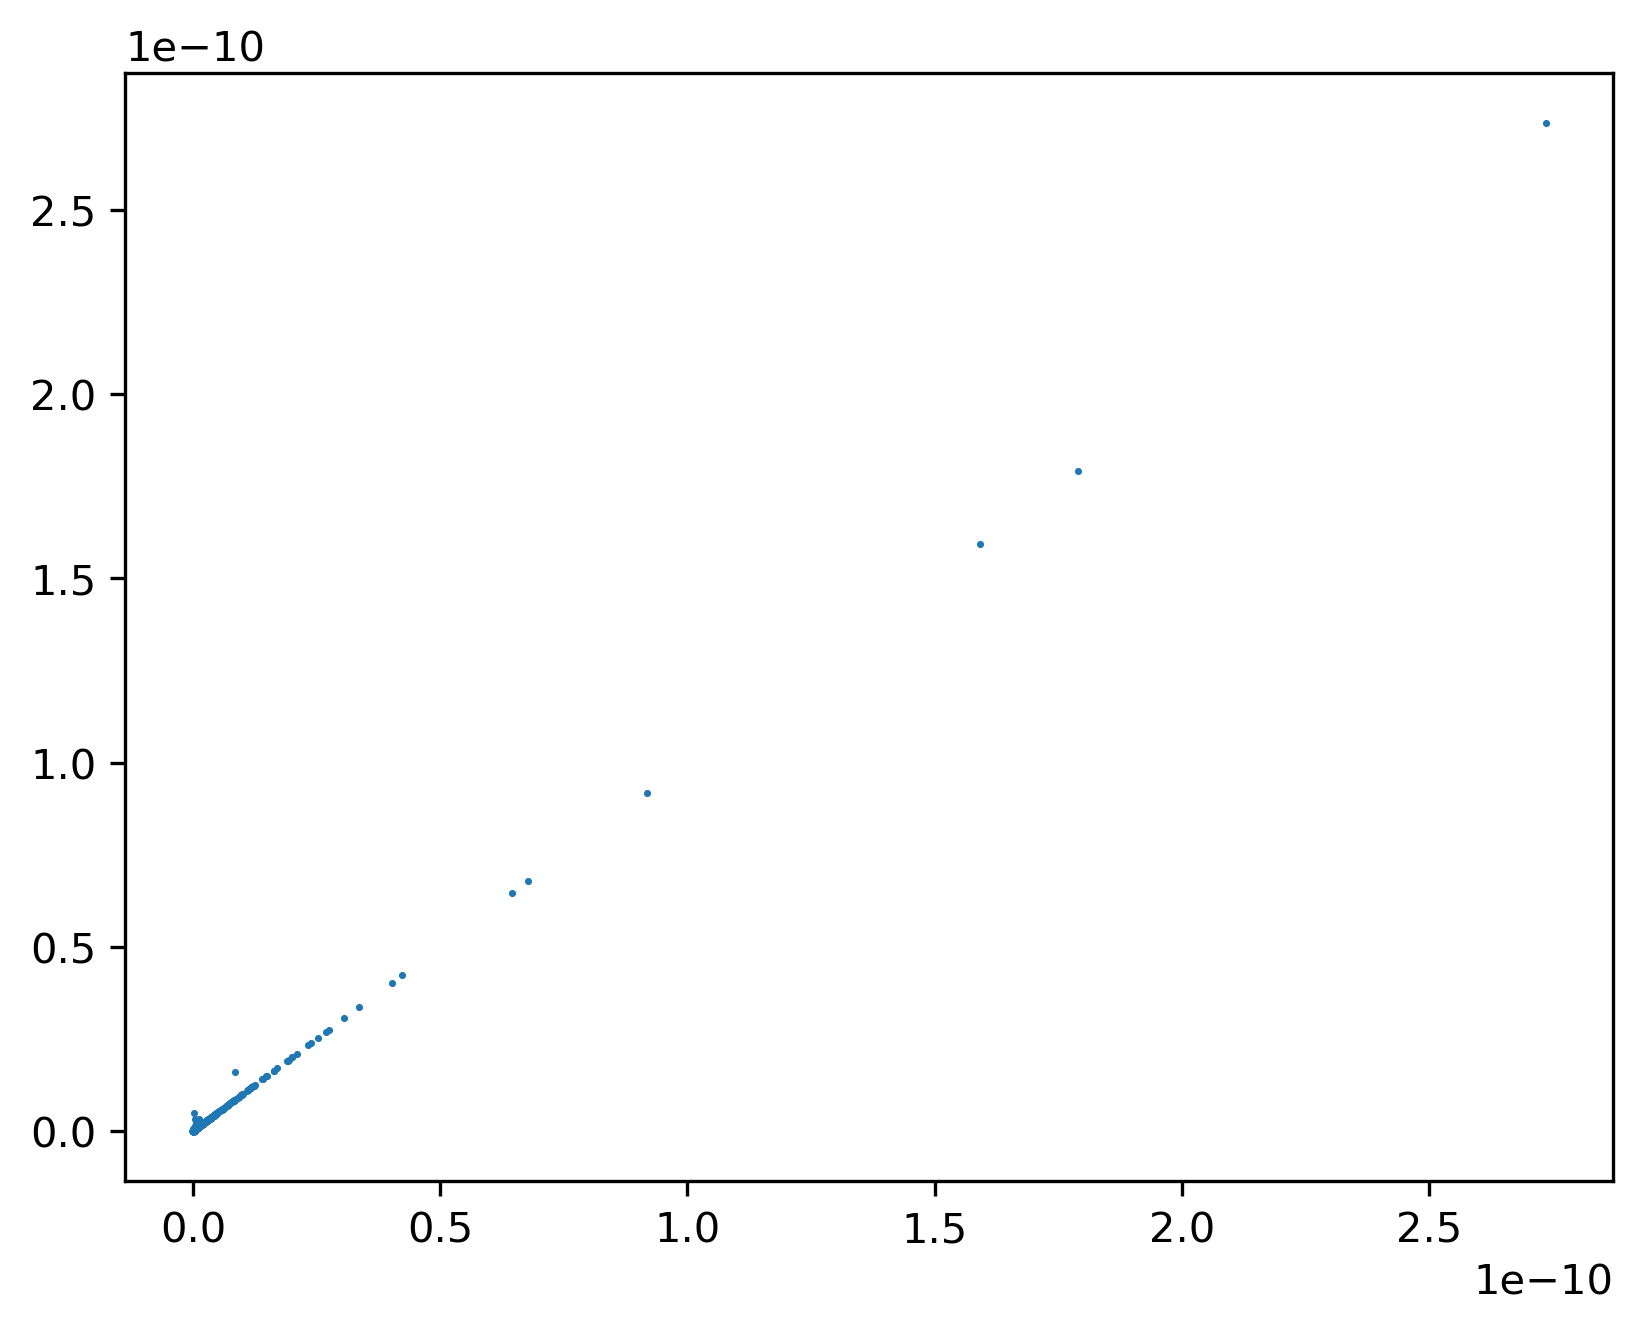

In [30]:
plt.scatter(X_train_nomodel['MED_ABS_DEV_x'], X_train_nomodel['MED_ABS_DEV_y'], s = 0.5)

### We need to bin our variables somehow. Why not use Bayesian blocks? Increasing the value of ncp_prior decreases the number of blocks found.

TFRAC_ABO3E
[0.23830948 0.37054068 0.42680862 0.47727884 0.55977988 0.60333026
 0.6593275  0.98312236]


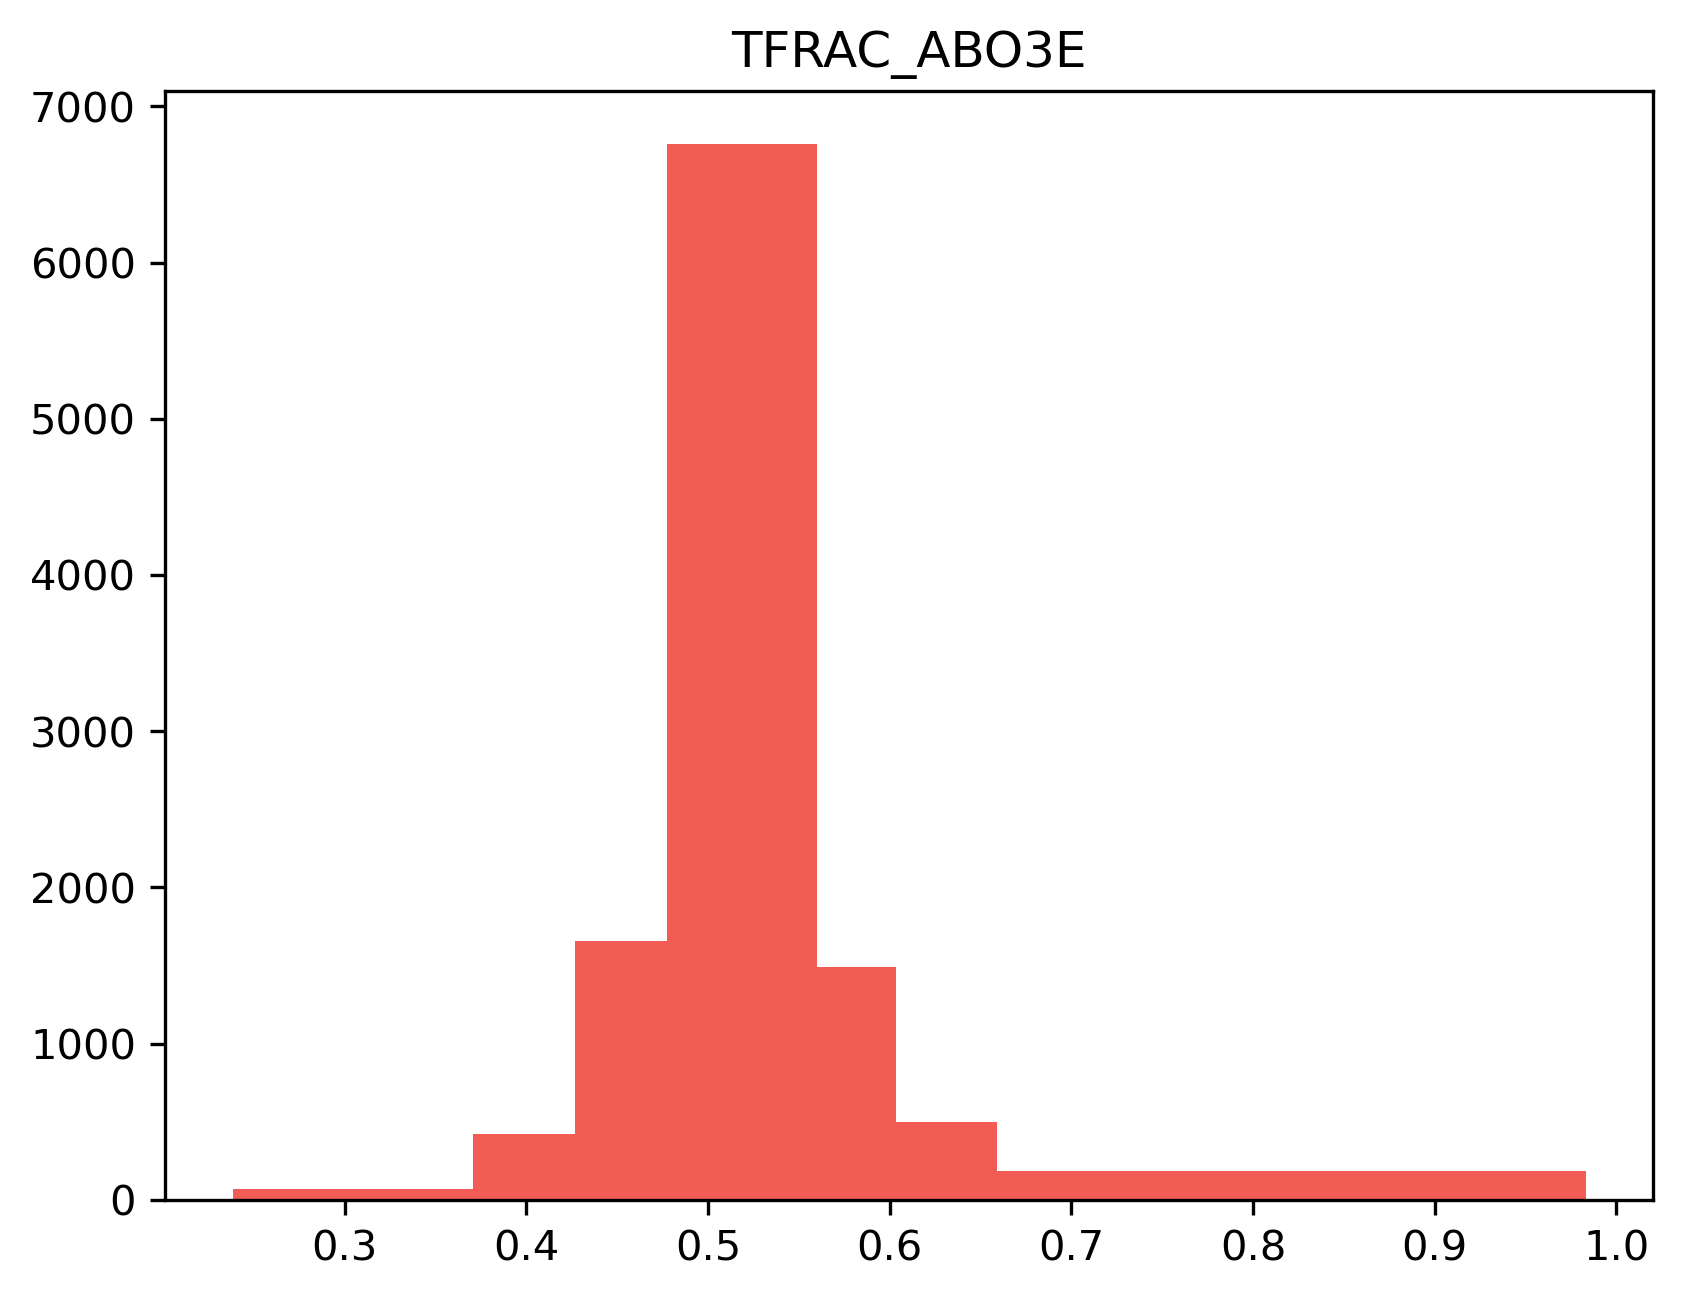

LIN_NSIGMA
[ 0.04087398  3.84477595  4.862334    6.4996195   8.7899725  12.0244985
 24.3031065  24.327637  ]


TFRAC_ABO1E
[0.23883146 0.42079718 0.47474203 0.5140745  0.60328522 0.64502465
 0.71925701 0.98312236]


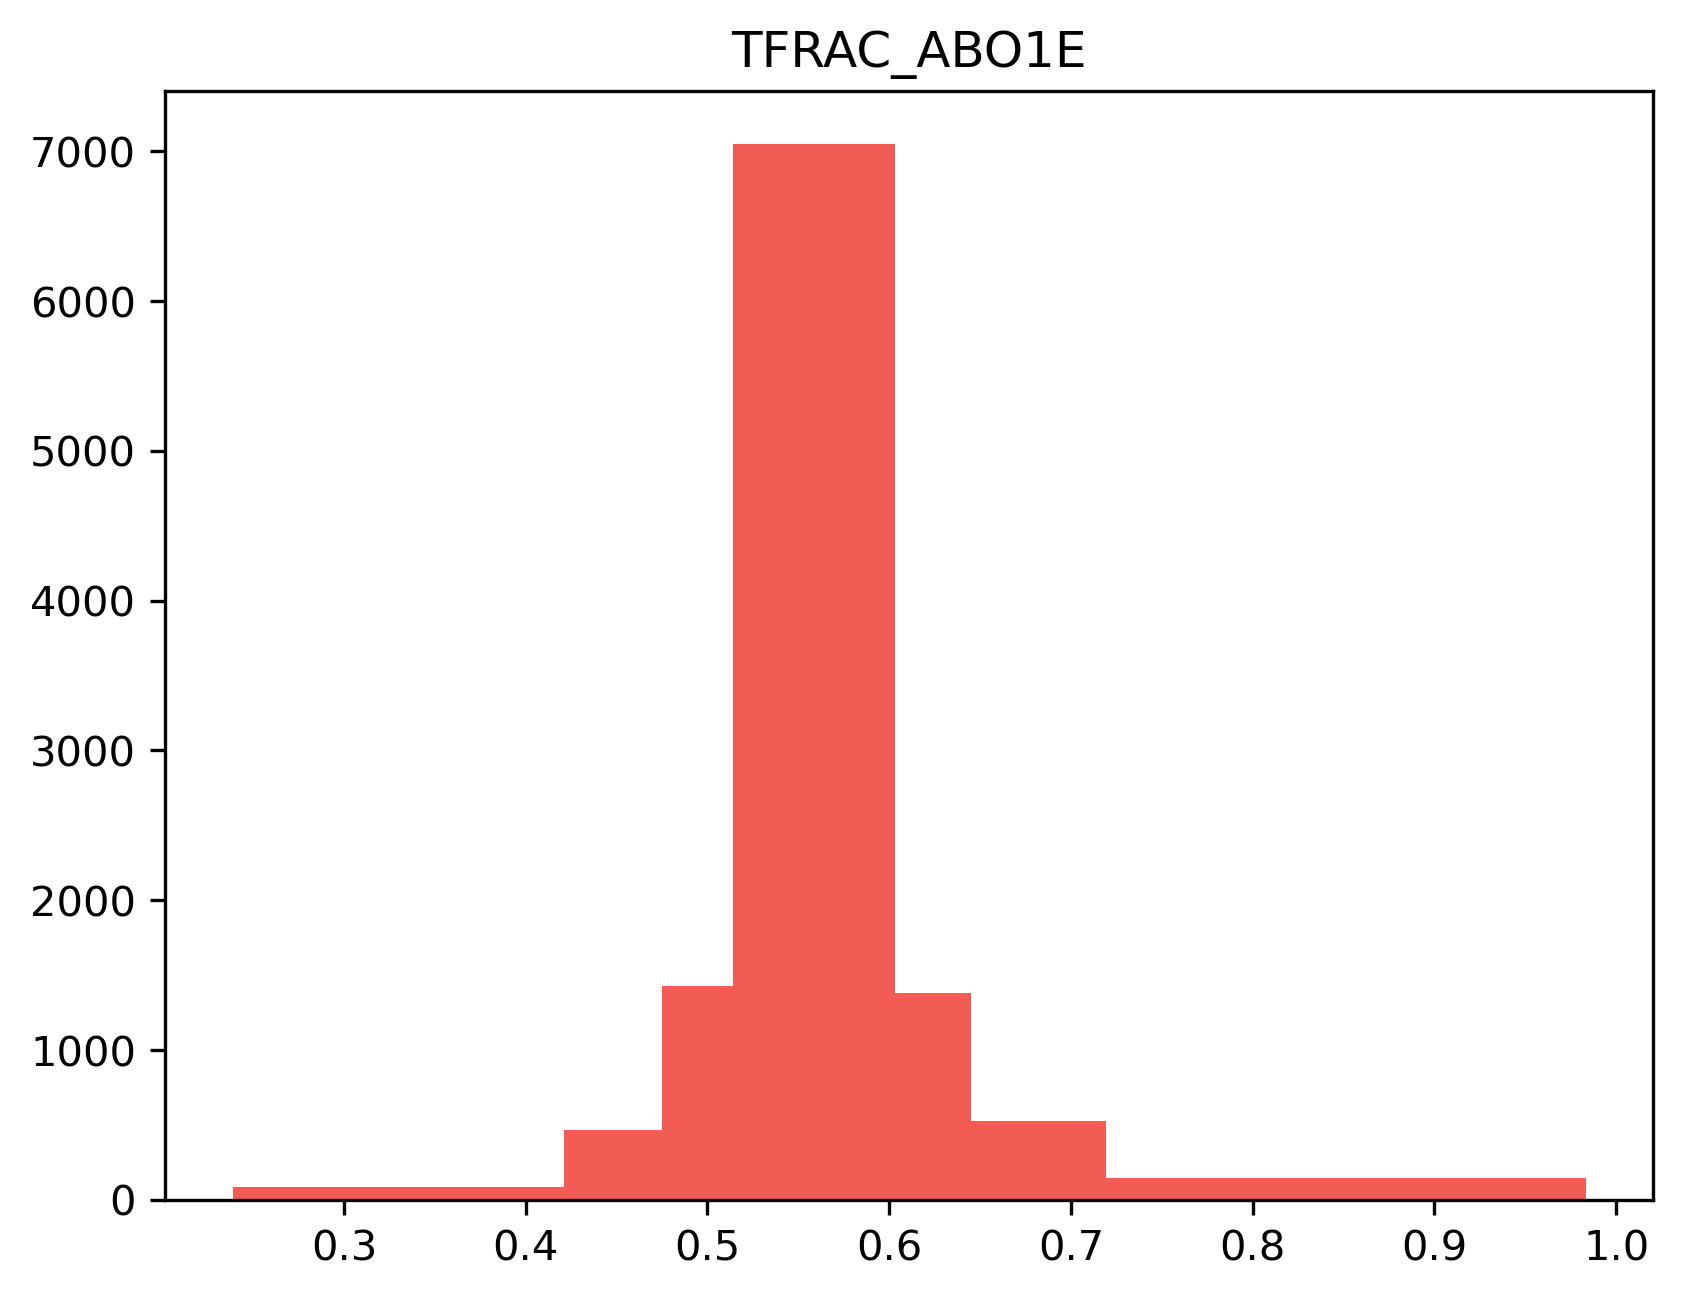

TFRAC_ABO5S
[0.00000000e+00 1.11022302e-16 3.49997809e-12 2.80787477e-09
 1.69743010e-06 6.10269262e-05 1.15400245e-03 5.74020296e-03
 1.30465007e-02 3.04651594e-02 8.65783834e-02 9.62955871e-01]


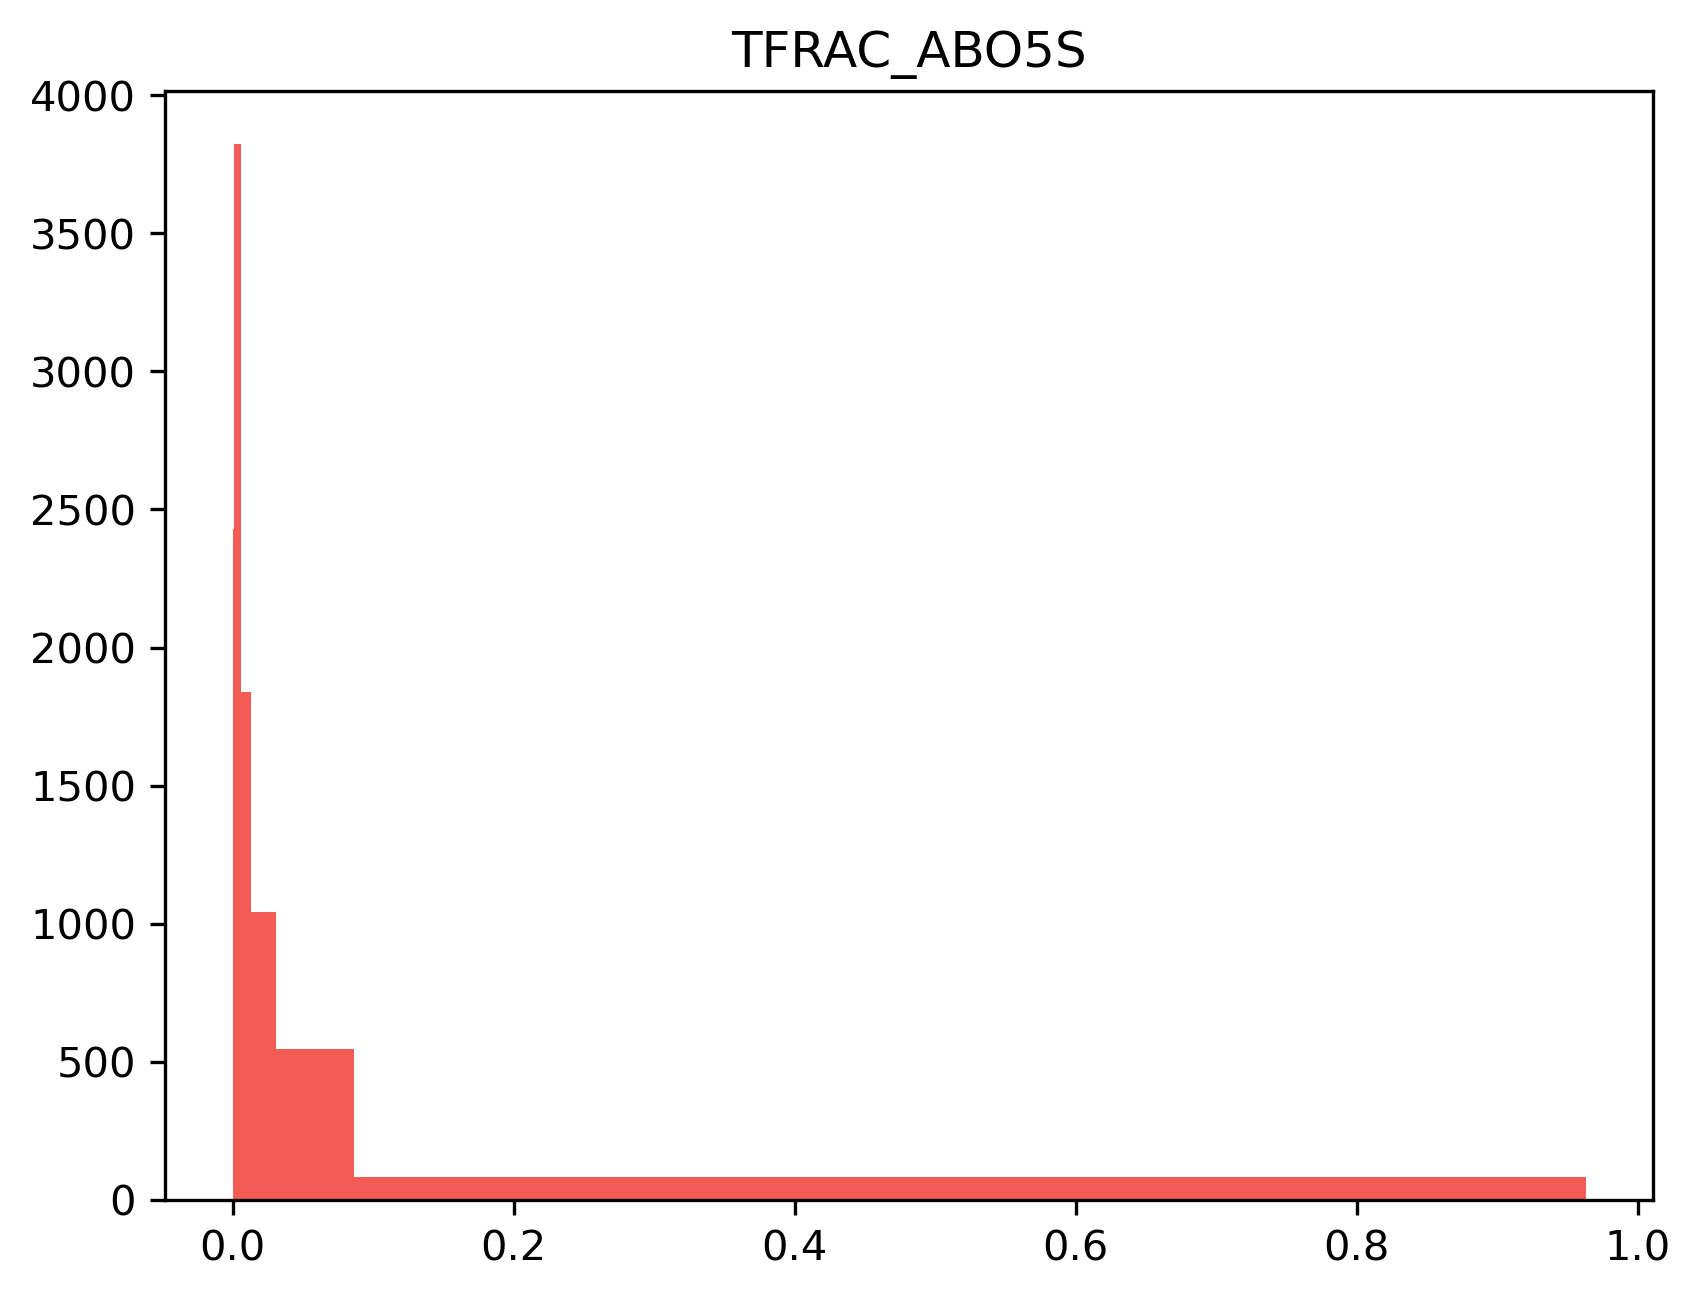

MEDMAXOFF
[-1.69938524 -0.58834819  0.04311617  0.95241942  1.46523823  2.30125149
  4.65656161]


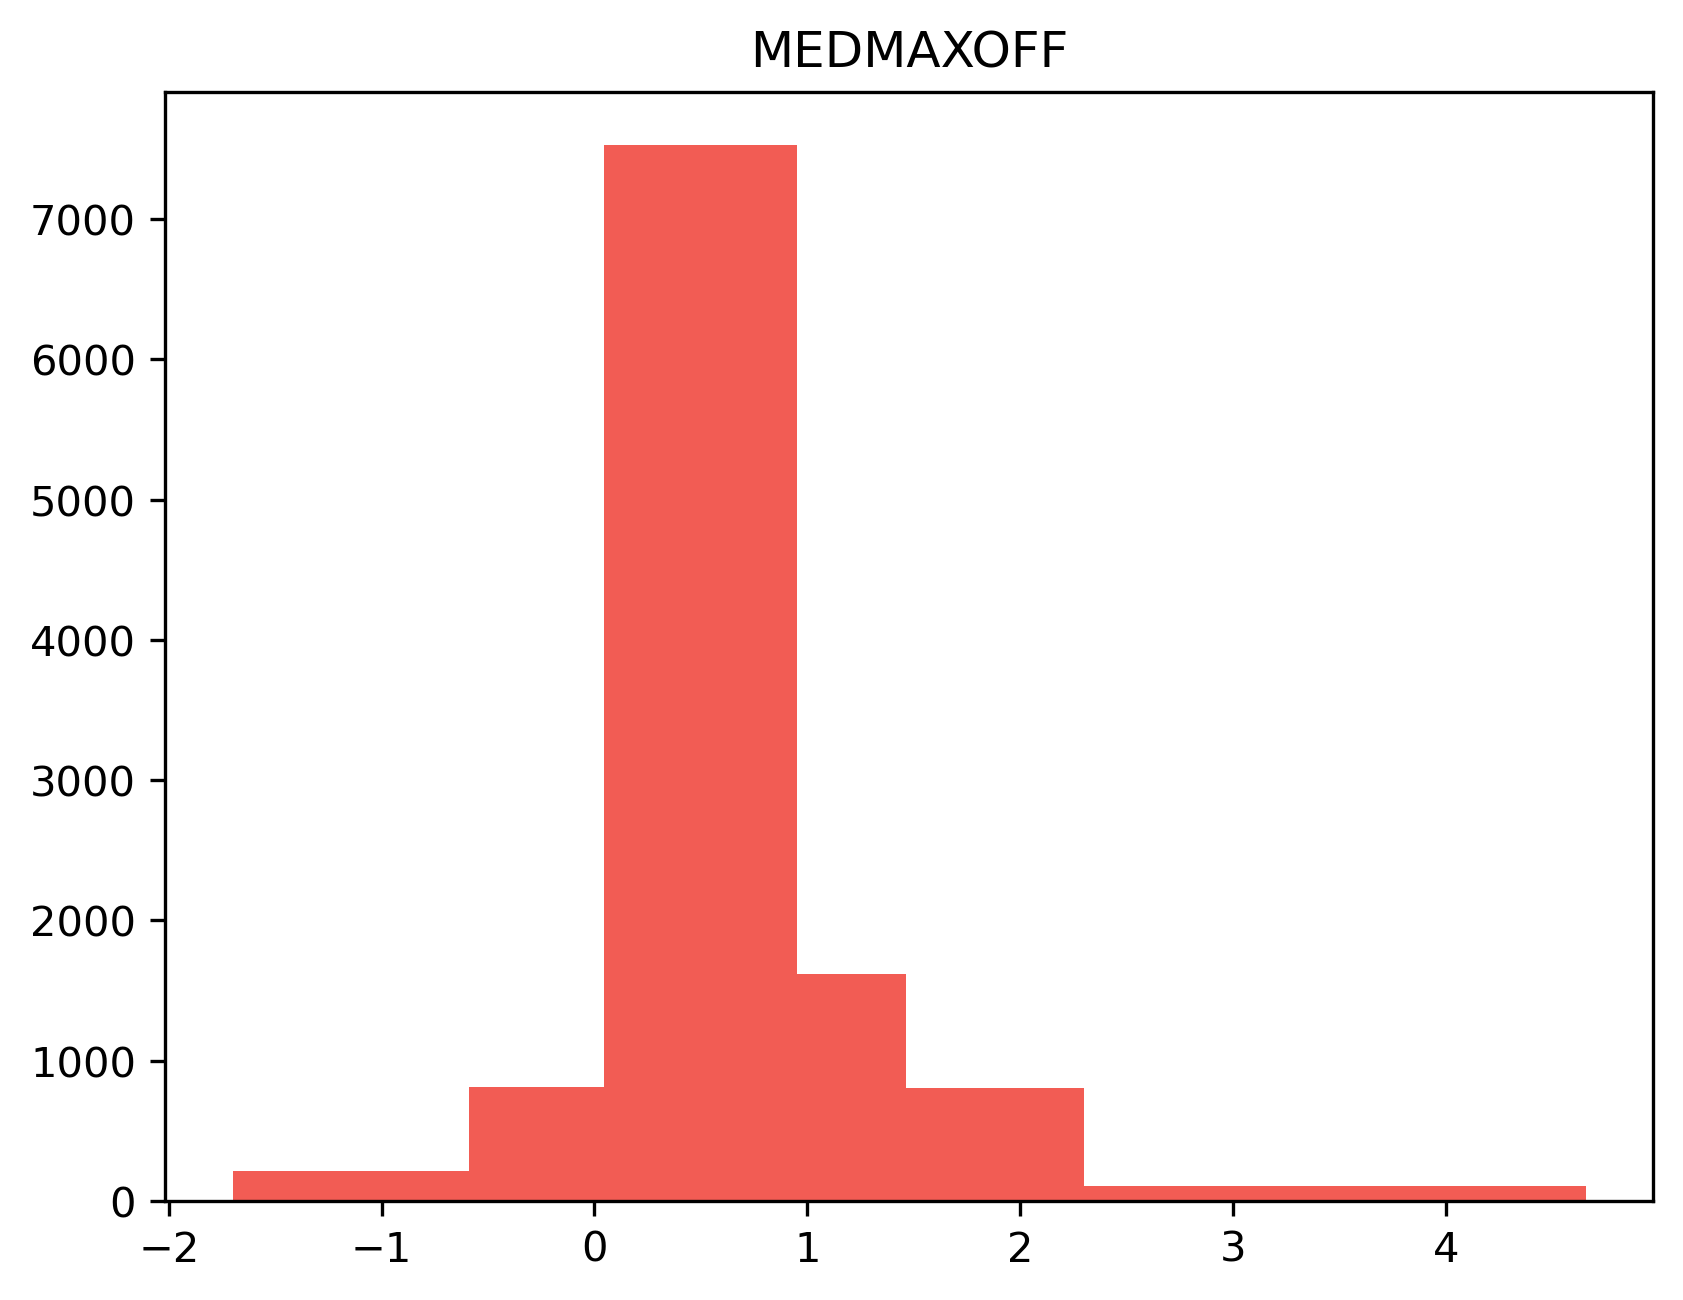

BB_MAXBLOCKS
[0.         0.150515   0.73856063 1.33232099 3.30513632]


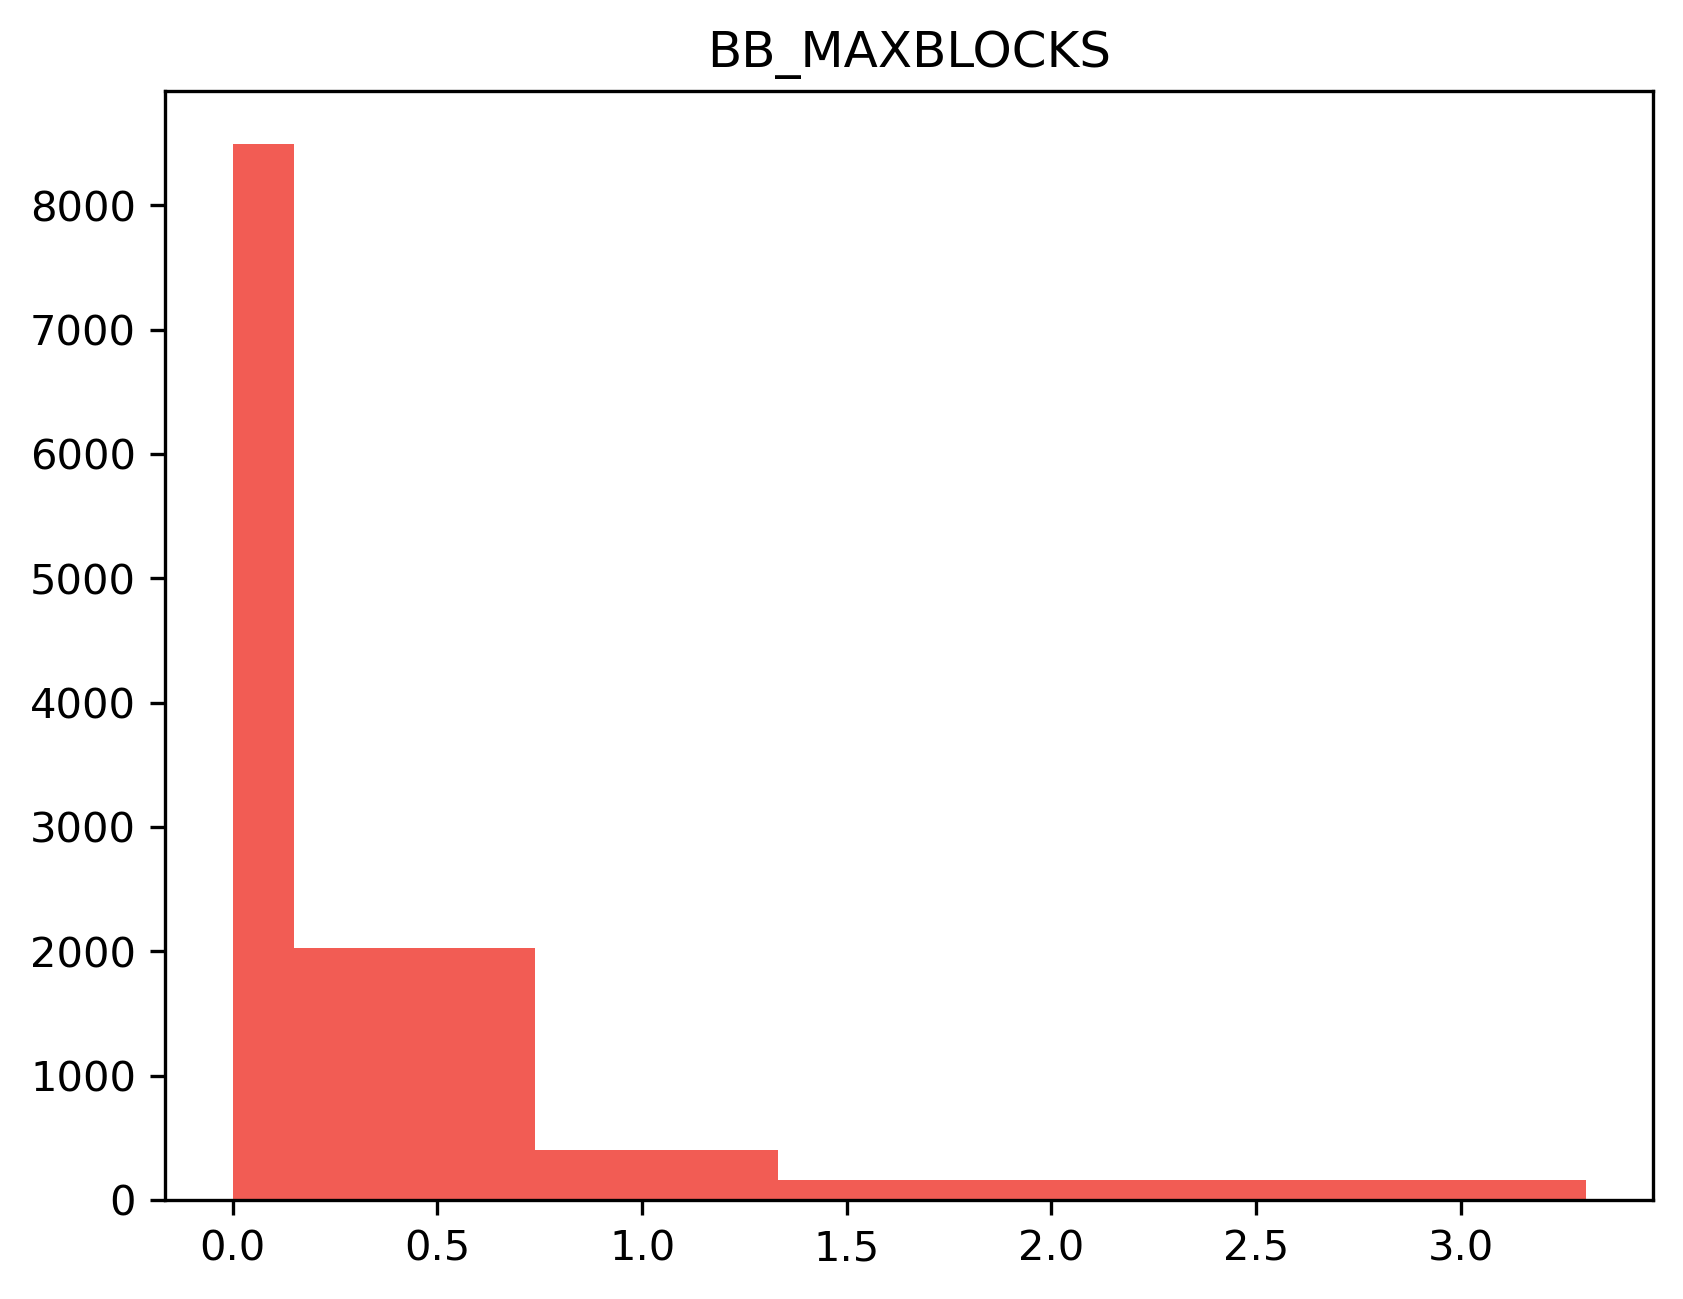

In [50]:
from astropy.stats import bayesian_blocks

variables_that_matter = ["TFRAC_ABO3E", "LIN_NSIGMA", "TFRAC_ABO1E",
                         "TFRAC_ABO5S"] #"TFRAC_ABO5E" is equal to "TFRAC_ABO3E" so excluded for now 

log_variables_that_matter = ["MEDMAXOFF", "BB_MAXBLOCKS"]

for v in variables_that_matter:
    bins = bayesian_blocks(X_train_nomodel[v], ncp_prior=200)
    print(v)
    print(bins)
    plt.hist(X_train_nomodel[v], bins=bins, histtype='stepfilled', color='#F25C54', edgecolor='none')
    plt.title(v)
    plt.show()

for v in log_variables_that_matter:
    bins = bayesian_blocks(np.log10(X_train_nomodel[v]), ncp_prior=200)
    print(v)
    print(bins)
    plt.hist(np.log10(X_train_nomodel[v]), bins=bins, histtype='stepfilled', color='#F25C54', edgecolor='none')
    plt.title(v)
    plt.show()